In [1]:
!pip3 install pyro-ppl 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 718 kB 9.7 MB/s 


In [2]:
!pip install extinction

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 418 kB 7.1 MB/s 


In [3]:
!pip install corner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors

import corner
import time as measure_time
import os
import math

import pyro

import pyro.distributions as dist
import pyro.distributions.constraints as constraints
from pyro.infer import SVI, Trace_ELBO,Predictive
from pyro.optim import Adam
from pyro.ops.stats import fit_generalized_pareto
from pyro import poutine

from scipy.interpolate import interp1d
import h5py
import extinction

from astropy.cosmology import FlatLambdaCDM

from spline_hsiao_fns import *

In [5]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(device)

cpu


##Get constants from files

In [131]:
W0 = np.loadtxt("W0_T21.txt")
W1 = np.loadtxt("W1_T21.txt")
W0_tensor = torch.as_tensor(W0).to(device)
W1_tensor = torch.as_tensor(W1).to(device)
time_knots = np.loadtxt("tau_knots_T21.txt")
wavelength_knots = np.loadtxt("l_knots_T21.txt")
L_sigma_epsilon = np.loadtxt("L_Sigma_epsilon_T21.txt")
L_sigma_epsilon_tensor = torch.as_tensor(L_sigma_epsilon, dtype = torch.float).to(device)
M0, sigma0, rv, tauA = np.loadtxt("M0_sigma0_RV_tauA_T21.txt")
cosmo = FlatLambdaCDM(H0 = 73.24, Om0 = 0.28)


In [7]:
xf = np.array([0.0, 1/2.65, 1/1.22, 1/0.60, 1/0.547, 1/0.467, 1/0.411, 1/0.27, 1/0.26])
x0 = 4.596
gamma_f = 0.99
c3 = 3.23
c4 = 0.41
c5 = 5.9

In [8]:
g_wavelengths, _, g_norm_throughput = np.loadtxt("g_PS1.txt", skiprows = 2, unpack = True)
r_wavelengths, _, r_norm_throughput = np.loadtxt("r_PS1.txt", skiprows = 2, unpack = True)
i_wavelengths, _, i_norm_throughput = np.loadtxt("i_PS1.txt", skiprows = 2, unpack = True)
z_wavelengths, _, z_norm_throughput = np.loadtxt("z_PS1.txt", skiprows = 2, unpack = True)

Read in metadata for Foundation dataset

In [202]:
meta = pd.read_csv("meta.txt", sep='\s+', index_col = False, names = ['SNID','PEAKMJD','MWEBV','REDSHIFT_HELIO','REDSHIFT_CMB','REDSHIFT_CMB_ERR'], skiprows = 2)

In [203]:
sample_size = 50
meta = meta.sample(n = sample_size)

In [204]:
tmax_dict = {}
mwebv_dict = {}
z_helio_dict = {}
z_cmb_dict = {}
for index, row in meta.iterrows():
  name = row['SNID']
  tmax = row['PEAKMJD']
  mwebv = row['MWEBV']
  z_helio = row['REDSHIFT_HELIO']
  z_cmb = row['REDSHIFT_CMB']
  tmax_dict[name] = tmax
  mwebv_dict[name] = mwebv
  z_helio_dict[name] = z_helio
  z_cmb_dict[name] = z_cmb

In [205]:
def get_fluxes_from_file(filename, tmax, z_helio):
  df = pd.read_csv(filename, sep=" ", header = 0, index_col = False, names = ['MJD', "FLT", 'FLUXCAL', 'FLUXCALERR', 'MAG', 'MAGERR'])
  df = df.dropna()

  # Remove time points outside of [-10., 40.]
  df['adj_time'] = (df.MJD - tmax) / (1 + z_helio)
  mask = (df['adj_time'] < 40.) & (df['adj_time'] > -10.0)
  df = df[mask]

  # Separate based on bands
  g_time = df.adj_time[df.FLT=='g'].values
  r_time = df.adj_time[df.FLT=='r'].values
  i_time = df.adj_time[df.FLT=='i'].values
  z_time = df.adj_time[df.FLT=='z'].values

  g_flux = df.FLUXCAL[df.FLT=='g'].values
  r_flux = df.FLUXCAL[df.FLT=='r'].values
  i_flux = df.FLUXCAL[df.FLT=='i'].values
  z_flux = df.FLUXCAL[df.FLT=='z'].values

  g_fluxerr = df.FLUXCALERR[df.FLT=='g'].values
  r_fluxerr = df.FLUXCALERR[df.FLT=='r'].values
  i_fluxerr = df.FLUXCALERR[df.FLT=='i'].values
  z_fluxerr = df.FLUXCALERR[df.FLT=='z'].values

  times_dict = {'g':g_time, 'r':r_time, 'i':i_time, 'z':z_time}

  observed_fluxes = [torch.as_tensor(g_flux).to(device), torch.as_tensor(r_flux).to(device), torch.as_tensor(i_flux).to(device), torch.as_tensor(z_flux).to(device)]

  flux_errors = [torch.as_tensor(g_fluxerr).to(device), torch.as_tensor(r_fluxerr).to(device), torch.as_tensor(i_fluxerr).to(device), torch.as_tensor(z_fluxerr).to(device)]

  # observed_fluxes = np.array([g_flux, r_flux, i_flux, z_flux])
  # observed_fluxes = []
  # for array in [g_flux, r_flux, i_flux, z_flux]:
  #   for i in array:
  #     observed_fluxes.append(i)

  # flux_errors = []
  # for array in [g_fluxerr, r_fluxerr, i_fluxerr, z_fluxerr]:
  #   for i in array:
  #     flux_errors.append(i)
  # flux_errors = np.array([g_fluxerr, r_fluxerr, i_fluxerr, z_fluxerr])

  return observed_fluxes, flux_errors, times_dict

In [206]:
ZPT = torch.as_tensor(27.5).to(device)
M0 = torch.as_tensor(-19.5).to(device)
gamma = torch.as_tensor(np.log(10) / 2.5).to(device)
gamma_numpy = np.log(10) / 2.5

hsiao_phase, hsiao_wave, hsiao_flux = read_model_grid()

bands = ['g', 'r', 'i', 'z']
wavelengths_dict = {'g':g_wavelengths, 'r':r_wavelengths, 'i':i_wavelengths, 'z':z_wavelengths}
norm_throughput_dict = {'g':g_norm_throughput, 'r':r_norm_throughput, 'i':i_norm_throughput, 'z':z_norm_throughput}
eps_cov = torch.as_tensor(np.matmul(L_sigma_epsilon, L_sigma_epsilon.T), dtype = torch.float)

Things we can pre-calculate / helper functions
---



In [207]:
def get_lambda_int_for_band(band_wavelengths, z):
  source_wavelengths = band_wavelengths / (1 + z)
  return np.linspace(np.min(source_wavelengths), np.max(source_wavelengths), 75)

In [208]:
def calculate_band_dependent_stuff(times_dict, z_helio, Av_obs, rv):
  band_Jl = {}
  band_h = {}
  band_Jt = {}
  # band_xis_matrix = {}
  band_S0 = {}  

  for band in bands:
    # Calculate Jt
    times_to_interpolate = times_dict[band]
    Jt = spline_coeffs_irr(times_to_interpolate, time_knots, invKD_irr(time_knots))
    band_Jt[band] = torch.as_tensor(Jt.T).to(device)

    # Calculate wavelengths to interpolate
    band_wavelengths = wavelengths_dict[band]
    wavelengths_to_interpolate = get_lambda_int_for_band(band_wavelengths, z = z_helio)

    # Calculate Jl (J matrix for wavelengths)
    Jl = spline_coeffs_irr(wavelengths_to_interpolate, wavelength_knots, invKD_irr(wavelength_knots))
    band_Jl[band] = torch.as_tensor(Jl).to(device)

    # Interpolate throughput wavelengths
    band_norm_throughput = norm_throughput_dict[band]
    throughput_interpolator = interp1d(band_wavelengths, band_norm_throughput)
    b = throughput_interpolator([band_wavelengths[0]] + list(wavelengths_to_interpolate[1:-1] * (1 + z_helio)) + [band_wavelengths[-1]])

    # Calculate S0 matrix
    S0 = np.zeros((len(wavelengths_to_interpolate), len(times_to_interpolate)))
    for i, wavelength in enumerate(wavelengths_to_interpolate):
      for j, time_point in enumerate(times_to_interpolate):
        S0[i][j] = interpolate_hsiao(time_point, wavelength, hsiao_phase, hsiao_wave, hsiao_flux)
    band_S0[band] = torch.as_tensor(S0).to(device)

    # Calculate h
    xis_obs = extinction.fitzpatrick99(wavelengths_to_interpolate*(1 + z_helio), Av_obs, 3.1)
    dLambda = wavelengths_to_interpolate[1] - wavelengths_to_interpolate[0]
    h = (1 + z_helio) * dLambda * b * wavelengths_to_interpolate * np.exp(-gamma_numpy * xis_obs)
    band_h[band] = torch.as_tensor(h).to(device)

  return band_Jt, band_Jl, band_S0, band_h

In [209]:
def get_xis_matrix(times_dict, rv, z_helio):
  band_xis_matrix = {}

  for band in bands:
    times_to_interpolate = times_dict[band]
    band_wavelengths = wavelengths_dict[band]
    wavelengths_to_interpolate = get_lambda_int_for_band(band_wavelengths, z = z_helio)

    Jf = torch.as_tensor(spline_coeffs_irr(1e4/wavelengths_to_interpolate, xf, invKD_irr(xf)), dtype = torch.float)
    xis = 1 + torch.matmul(Jf,rv_extinction(rv).float()) / rv.float()
    xis_matrix = torch.tile(xis, (len(times_to_interpolate),1)).T
    band_xis_matrix[band] = xis_matrix.to(device)

  return band_xis_matrix

In [210]:
def rv_extinction(rv):
  ## rewrite this using matrices
  c2 = -0.824 + 4.717 / rv
  c1 = 2.03 - 3.007*c2
  d1 = (xf[7]**2) / ((xf[7]**2 - x0**2)**2 + (gamma_f**2)*(xf[7]**2))
  d2 = (xf[8]**2) / ((xf[8]**2 - x0**2)**2 + (gamma_f**2)*(xf[8]**2))


  yf1 = -rv
  yf2 = 0.26469*rv/3.1 - rv
  yf3 = 0.82925*rv/3.1 - rv
  yf4 = -0.422809 + 1.00270*rv + (2.13572e-4)*(rv**2) - rv
  yf5 = -5.13540e-2 + 1.00216*rv - (7.35778e-5)*(rv**2) - rv
  yf6 = 0.700127 + 1.00184*rv - (3.32598e-5)*(rv**2) -rv
  yf7 = 1.19456 + 1.01707*rv - (5.46959e-3)*(rv**2) + (7.97809e-4)*(rv**3) - (4.45636e-5)*(rv**4) - rv
  yf8 = c1 + c2*xf[7] + c3*d1
  yf9 = c1 + c2*xf[8] + c3*d2

  # const_matrix = []
  return torch.as_tensor([yf1, yf2, yf3, yf4, yf5, yf6, yf7, yf8, yf9])

In [211]:
sn_band_dependent_dict = {}
sn_time_dicts = {}

all_observed_fluxes = []
all_flux_errors = []

for sn in meta.SNID.values:
  tmax = tmax_dict[sn]
  z_helio = z_helio_dict[sn]
  EBV_MW = mwebv_dict[sn]
  z_cmb = z_cmb_dict[sn]

  Av_obs = EBV_MW * 3.1
  observed_fluxes, flux_errors, times_dict = get_fluxes_from_file(sn + ".dat", tmax, z_helio)

  sn_band_dependent_dict[sn] = calculate_band_dependent_stuff(times_dict, z_helio, Av_obs, rv)

  all_observed_fluxes.append(observed_fluxes)

  # for i in observed_fluxes:
  #   all_observed_fluxes.append(i)

  # for i in flux_errors:
  #   all_flux_errors.append(i)
  # all_observed_fluxes.append(observed_fluxes)
  sn_time_dicts[sn] = times_dict
  all_flux_errors.append(flux_errors)

In [212]:
len(all_flux_errors)

50

In [213]:
max([len(i) for i in all_flux_errors])
# for i in all_flux_errors:
#   print(len(i))

4

In [214]:
all_flux_errors_tensor = torch.zeros(sample_size, 4, 24) + 0.1
all_observed_fluxes_tensor = torch.zeros(sample_size, 4, 24) + 0.1
mask_tensor = torch.zeros(sample_size, 4, 24, dtype=torch.bool)

In [215]:
for i in range(len(all_observed_fluxes)):
  for j in range(4):
    for k in range(len(all_observed_fluxes[i][j])):
      all_flux_errors_tensor[i][j][k] = all_flux_errors[i][j][k]
      all_observed_fluxes_tensor[i][j][k] = all_observed_fluxes[i][j][k]
      mask_tensor[i][j][k] = 1

In [216]:
nu_args = torch.zeros(len(L_sigma_epsilon)).to(device), torch.eye(len(L_sigma_epsilon)).to(device)
theta_args = torch.as_tensor(0.).to(device), torch.as_tensor(1.0).to(device)
mu_arg = torch.as_tensor(10.0).to(device)
av_arg = torch.as_tensor(1 / 0.252).to(device)

zeros = torch.zeros(6).to(device)

In [217]:
len(meta.SNID.values)

50

The "old" (non-vectorized) model is below.

In [218]:
def model_vi_with_params_faster():

  rv_mean = pyro.sample("rv_mean", dist.Uniform(1., 5.))
  rv_std = pyro.sample("rv_std", dist.HalfNormal(2.))

  tau = pyro.sample("tau", dist.HalfNormal(1.))

  for sn_index in pyro.plate("SNe", sample_size):

    sn = meta.SNID.values[sn_index]
    times_dict = sn_time_dicts[sn]
    # tmax = tmax_dict[sn]
    z_helio = z_helio_dict[sn]
    # EBV_MW = mwebv_dict[sn]
    z_cmb = z_cmb_dict[sn]

    # Av_obs = EBV_MW * 3.1
    # observed_fluxes, flux_errors, times_dict = get_fluxes_from_file(sn + ".dat", tmax, z_helio)

    # Calculate band-dependent quantities (Jl, Jt, xis, S0, etc.)
    rv = pyro.sample("rv"+ str(sn_index), dist.Normal(rv_mean, rv_std))

    band_xis_matrix = get_xis_matrix(times_dict, rv, z_helio)
    # band_Jt, band_Jl, band_xis_matrix, band_S0, band_h = calculate_band_dependent_stuff(times_dict, z_helio, Av_obs, rv)
    mu_mean = torch.as_tensor(cosmo.distmod(z_cmb).value).to(device)

    nu = pyro.sample("nu" + str(sn_index), dist.MultivariateNormal(*nu_args))
    epsilon_interior = torch.matmul(L_sigma_epsilon_tensor.float(), torch.squeeze(nu).float())

    theta = pyro.sample("theta" + str(sn_index), dist.Normal(*theta_args))

    mu_s = pyro.sample("mu_s" + str(sn_index), dist.Normal(mu_mean, mu_arg))

    dMs = torch.tensor(0.).to(device)

    Av = pyro.sample("Av" + str(sn_index), dist.Exponential(1. / tau))

    # epsilon = torch.zeros(W0.shape)   ## populate epsilon matrix
    # epsilon[1:-1] = torch.transpose(torch.reshape(epsilon_interior, (6,9)), 0, 1)
    epsilon = torch.vstack((zeros, torch.transpose(torch.reshape(epsilon_interior, (6,4)), 0, 1), zeros))

    W = W0_tensor + theta*W1_tensor + epsilon

    generated_fluxes = np.empty(4, object)

    band_Jt, band_Jl, band_S0, band_h = sn_band_dependent_dict[sn]


    for band_index, band in enumerate(bands):
      Jl = band_Jl[band]
      S0 = band_S0[band]
      xis_matrix = band_xis_matrix[band]
      h = band_h[band]
      Jt = band_Jt[band]

      JlWJt = torch.matmul(Jl, torch.matmul(W, Jt))

      Stilde = S0 * torch.exp(-gamma * (JlWJt + Av * xis_matrix))

      f = 10**(0.4 * (ZPT - mu_s - M0 - dMs)) * torch.matmul(h, Stilde)
      generated_fluxes[band_index] = f

    for i in pyro.plate("bands" + str(sn_index), band_index + 1):
      with pyro.plate("observations" + str(bands[i]) + str(sn_index)):
          pyro.sample("flux" + str(bands[i]) + str(sn_index), dist.Normal(generated_fluxes[i], all_flux_errors[sn_index][i]), obs = all_observed_fluxes[sn_index][i])


I have to do a bunch of janky stuff to get the indexing to work with vectorization.

In [219]:
all_mu_means = torch.as_tensor([torch.as_tensor(cosmo.distmod(z_cmb_dict[sn]).value).to(device) for sn in meta.SNID.values])

In [220]:
all_z_helios = np.array([z_helio_dict[sn] for sn in meta.SNID.values])

In [221]:
def get_xis_matrix_vectorized(rv, single_rv = True):
  all_band_xis_matrices = torch.zeros((sample_size, 4, 75, 24))
  if not single_rv:
    for sn_index, sn in enumerate(meta.SNID.values):
      times_dict = sn_time_dicts[sn]
      z_helio = z_helio_dict[sn]
      band_xis_matrix = get_xis_matrix(times_dict, rv[sn_index], z_helio)
      # print(np.array(list(band_xis_matrix.values())).shape)
      # print(np.array(list(band_xis_matrix.values()))[0].shape)
      this_matrix = list(band_xis_matrix.values())
      for i, band_value in enumerate(this_matrix):
        # print(band_value.shape)
        all_band_xis_matrices[sn_index][i][:75,:len(band_value[0])] = band_value
      # all_band_xis_matrices.append(np.array(list(band_xis_matrix.values())))
  else:
    for sn_index, sn in enumerate(meta.SNID.values):
      times_dict = sn_time_dicts[sn]
      z_helio = z_helio_dict[sn]
      band_xis_matrix = get_xis_matrix(times_dict, rv, z_helio)
      # print(np.array(list(band_xis_matrix.values())).shape)
      # print(np.array(list(band_xis_matrix.values()))[0].shape)
      this_matrix = list(band_xis_matrix.values())
      for i, band_value in enumerate(this_matrix):
        # print(band_value.shape)
        all_band_xis_matrices[sn_index][i][:75,:len(band_value[0])] = band_value

  return all_band_xis_matrices

In [222]:
def get_all_band_dependent_arrays():
  all_Jt = []
  all_Jl = []
  all_S0 = []
  all_h = []
  for sn in meta.SNID.values:
    band_Jt, band_Jl, band_S0, band_h = sn_band_dependent_dict[sn]
    all_Jt.append(np.array(list(band_Jt.values())))
    all_Jl.append(np.array(list(band_Jl.values())))
    all_S0.append(np.array(list(band_S0.values())))
    all_h.append(np.array(list(band_h.values())))
  return np.array(all_Jt), np.array(all_Jl), np.array(all_S0), np.array(all_h)

In [223]:
all_Jt, all_Jl, all_S0, all_h = get_all_band_dependent_arrays()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The input object of type 'Tensor' is an array-like implementing one

In [224]:
torch.transpose(all_flux_errors_tensor, 0, 2).shape

torch.Size([24, 4, 50])

In [225]:
tauA

0.194

## Vectorized Model Definition

In [226]:
def training_model_vectorized():

  # rv_mean = pyro.sample("rv_mean", dist.Uniform(1., 5.))
  # rv_std = pyro.sample("rv_std", dist.HalfNormal(2.))

  rv = pyro.sample("rv", dist.Uniform(1., 5.))

  # tau = pyro.sample("tau", dist.HalfNormal(1.))

  tau = torch.as_tensor(0.194)

  with pyro.plate("SNe", sample_size) as sn_index:

    sn = meta.SNID.values[sn_index]

    # Calculate band-dependent quantities (Jl, Jt, xis, S0, etc.)
    # rv = pyro.sample("rv", dist.Normal(rv_mean, rv_std))

    all_band_xis_matrix = get_xis_matrix_vectorized(rv)

    nu = pyro.sample("nu", dist.MultivariateNormal(*nu_args))
    epsilon_interior = torch.matmul(L_sigma_epsilon_tensor.float(), torch.t(torch.squeeze(nu).float()))

    theta = pyro.sample("theta", dist.Normal(*theta_args))

    mu_s = pyro.sample("mu_s", dist.Normal(all_mu_means[sn_index], mu_arg))

    dMs = torch.tensor(0.).to(device)

    Av = pyro.sample("Av", dist.Exponential(1. / tau))


    epsilon = torch.stack([torch.vstack((zeros, torch.transpose(torch.reshape(epsilon_interior[:,i], (6,4,)), 0, 1), zeros)) for i in range(torch.squeeze(nu).shape[0])])

    W = torch.stack([W0_tensor + theta[i]*W1_tensor + epsilon[i] for i in range(sample_size)])


    all_model_generated_fluxes = torch.zeros(sample_size, 4, 24)


    for i in sn_index:
      Jt = all_Jt[i]
      Jl = all_Jl[i]
      S0 = all_S0[i]
      h = all_h[i]
      xis_matrix = all_band_xis_matrix[i]
      xis_matrix = xis_matrix[xis_matrix != 0]

      # generated_fluxes = []

      for band_index, band in enumerate(bands):
        JlWJt = torch.matmul(Jl[band_index], torch.matmul(W[i], Jt[band_index]))

        Stilde = S0[band_index] * torch.exp(-gamma * (JlWJt + Av[i] * xis_matrix[band_index]))

        f = 10**(0.4 * (ZPT - mu_s[i] - M0 - dMs)) * torch.matmul(h[band_index], Stilde)
        # print(f)
        for k in range(len(f)):
          all_model_generated_fluxes[i][band_index][k] = f[k]

    with pyro.plate("bands"):
      with pyro.plate("observations"):
        with poutine.mask(mask = torch.transpose(mask_tensor, 0, 2)):
          pyro.sample("flux", dist.Normal(torch.transpose(all_model_generated_fluxes, 0, 2), torch.transpose(all_flux_errors_tensor, 0, 2)), obs = torch.transpose(all_observed_fluxes_tensor, 0, 2))

In [227]:
def train_with_params_faster(model, guide, lr=0.01, n_steps=5000, verbose= False):
  pyro.get_param_store().clear()
  # adam = pyro.optim.Adam({"lr": 0.05}, {"clip_norm": 10.0})
  adam = pyro.optim.ClippedAdam({"lr": lr, "betas": (0.95, 0.999)})
  svi = SVI(model, guide, adam, loss=Trace_ELBO())
  # print('hi')
  for step in range(n_steps):
      loss = svi.step()
      if verbose and step % 50 == 0:
            print('[iter {}]  loss: {:.4f}'.format(step, loss))
          ## if it hasn't decreased in 3 steps, end fitting
          # if step > 2000:
          #  if losses_every_500[-1] >= losses_every_500[-2] and losses_every_500[-2] >= losses_every_500[-3]:
          #   break


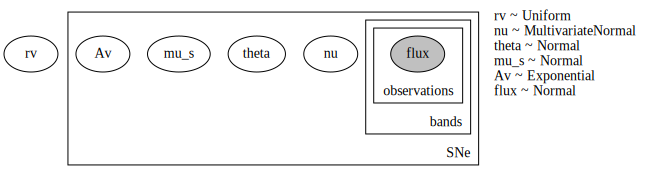

In [228]:
pyro.render_model(training_model_vectorized, render_distributions=True, render_params = True)

In [114]:
meta.SNID.values

array(['PS15atx', 'SN2017cii', 'PSNJ1602512', 'AT2017yk', 'PS15bbn',
       'ASASSN-17co', 'PS15mt', 'AT2016cvv', 'AT2017cfc', 'AT2016hns'],
      dtype=object)

In [115]:
digraph = pyro.render_model(training_model_vectorized,render_params = True)
digraph.edge("rv", "flux")
digraph.edge("mu_s", "flux")
digraph.edge("theta", "flux")
digraph.edge("nu", "flux")
digraph.edge("Av", "flux")

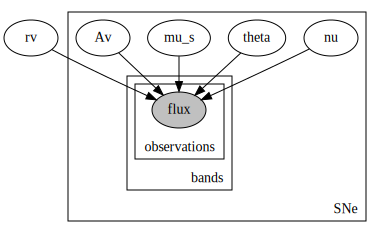

In [116]:
digraph

In [117]:
digraph.save()
digraph.render(filename = "Fitting_PGM_080822", format='eps', view = 1, cleanup = 1)

'Fitting_PGM_080822.eps'

In [118]:
training_model_vectorized()

In [119]:
# nuts_kernel = pyro.infer.NUTS(model_vi_with_params_faster, adapt_step_size=True)

# mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=200, warmup_steps=250, num_chains = 1)

# mcmc.run()


## Training attempts

In [164]:
## This takes approximately 6 hours to run
autoguide_laplace = pyro.infer.autoguide.AutoLaplaceApproximation(training_model_vectorized)
train_with_params_faster(training_model_vectorized, autoguide_laplace, lr = 0.01, n_steps=2000, verbose = True)

[iter 0]  loss: 134795747.4527
[iter 50]  loss: 27987096.1569
[iter 100]  loss: 4043703.4765
[iter 150]  loss: 249777.2400
[iter 200]  loss: 16435.0249
[iter 250]  loss: 7027.2241
[iter 300]  loss: 4237.1017
[iter 350]  loss: 3334.8078
[iter 400]  loss: 2856.5363
[iter 450]  loss: 2600.0533
[iter 500]  loss: 2476.3447
[iter 550]  loss: 2410.1128
[iter 600]  loss: 2371.1524
[iter 650]  loss: 2344.9097
[iter 700]  loss: 2324.8694
[iter 750]  loss: 2311.1116
[iter 800]  loss: 2297.9192
[iter 850]  loss: 2288.0719
[iter 900]  loss: 2279.0250
[iter 950]  loss: 2273.7658
[iter 1000]  loss: 2267.5530
[iter 1050]  loss: 2263.3252
[iter 1100]  loss: 2259.7346
[iter 1150]  loss: 2257.0700
[iter 1200]  loss: 2254.8777
[iter 1250]  loss: 2253.1273
[iter 1300]  loss: 2251.6586
[iter 1350]  loss: 2250.4768
[iter 1400]  loss: 2249.4240
[iter 1450]  loss: 2248.5391
[iter 1500]  loss: 2247.9949
[iter 1550]  loss: 2247.3637
[iter 1600]  loss: 2246.8985
[iter 1650]  loss: 2246.5796
[iter 1700]  loss: 224

In [165]:
autoguide_laplace.loc

Parameter containing:
tensor([-1.4129e+00, -1.1488e-01, -5.6215e-02, -2.3492e-01, -2.0220e-01,
        -5.4057e-01,  5.8480e-01,  2.0231e-01,  7.8844e-01, -3.4642e-01,
         5.1330e-01, -2.3167e-01, -3.9430e-01,  2.9628e-01, -7.3592e-01,
         3.4381e-01,  5.8587e-02, -6.7636e-01,  2.2437e-01,  2.7970e-01,
        -7.3203e-02,  2.0361e-02, -1.8859e-01,  2.8543e-02,  2.3528e-02,
        -4.7338e-01,  1.1474e+00,  8.9376e-01,  4.6069e-01,  9.8306e-01,
        -4.9962e-01, -1.3972e+00, -1.4803e+00, -7.6065e-01,  8.4203e-01,
        -1.1228e+00, -1.3922e-01,  2.6167e-01,  8.6603e-01,  9.5778e-01,
         2.2857e-01, -7.5276e-01,  6.7727e-01,  1.7117e-01, -2.3229e-01,
        -2.3083e-01, -6.9818e-01, -3.1665e-01, -4.4510e-01,  2.6693e+00,
        -4.6168e-01, -1.3331e+00, -1.8705e+00,  3.9741e+00, -2.0984e+00,
        -1.8492e+00, -1.9435e+00,  1.8187e+00,  2.3073e-01, -9.8110e-01,
         3.4903e-01,  1.2304e+00,  6.1392e-01,  6.3380e-01, -1.1156e+00,
         3.3715e-01, -2.5155e

In [166]:
from pyro.ops.hessian import hessian
guide_trace = poutine.trace(autoguide_laplace).get_trace()
model_trace = poutine.trace(
    poutine.replay(autoguide_laplace.model, trace=guide_trace)
).get_trace()
loss = guide_trace.log_prob_sum() - model_trace.log_prob_sum()

H = hessian(loss, autoguide_laplace.loc)

In [167]:
H

tensor([[ 1.4865e+04, -2.6467e-01,  3.9055e-01,  ..., -3.9908e+02,
         -7.3066e+04, -2.8722e+02],
        [-2.6467e-01,  1.0887e+00,  2.7358e-02,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 3.9055e-01,  2.7358e-02,  1.3463e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [-3.9908e+02,  0.0000e+00,  0.0000e+00,  ...,  2.3900e+03,
          0.0000e+00,  0.0000e+00],
        [-7.3066e+04,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          4.5052e+05,  0.0000e+00],
        [-2.8722e+02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  1.7358e+03]], dtype=torch.float64)

In [168]:
with torch.no_grad():
  loc = autoguide_laplace.loc.detach()
  cov = H.inverse()
  scale = cov.diagonal().sqrt()
  cov /= scale[:, None]
  cov /= scale[None, :]
  scale_tril = torch.linalg.cholesky(cov)

_LinAlgError: ignored

In [162]:
gaussian_guide = pyro.infer.autoguide.AutoMultivariateNormal(autoguide_laplace.model)
gaussian_guide._setup_prototype()
# Set detached loc, scale, scale_tril parameters as computed above.
del gaussian_guide.loc
del gaussian_guide.scale
gaussian_guide.register_buffer("loc", loc)
gaussian_guide.register_buffer("scale", scale)

In [163]:
gaussian_guide.get_posterior()

ValueError: ignored

In [170]:
map_estimate = autoguide_laplace.loc

In [174]:
map_estimate.shape

torch.Size([271])

In [175]:
270/10

27.0

In [173]:
from scipy.special import expit
mu_R = 1 + (5-1)*expit(-1.4129)
mu_R

1.7831082125623725

In [ ]:
np.save("training_laplace_approx_072422.npy", laplace_approx)

In [ ]:
np.save("training_laplace_approx_mean_072422.npy", laplace_approx.get_posterior().loc.detach().numpy())
np.save("training_laplace_approx_scale_tril_072422.npy", laplace_approx.get_posterior().scale_tril.detach().numpy())

In [ ]:
from google.colab import files
files.download('training_laplace_approx_072422.npy')
files.download('training_laplace_approx_mean_072422.npy')
files.download('training_laplace_approx_scale_tril_072422.npy')

In [235]:
autoguide_normal = pyro.infer.autoguide.AutoMultivariateNormal(training_model_vectorized, init_loc_fn = pyro.infer.autoguide.initialization.init_to_sample())
train_with_params_faster(training_model_vectorized, autoguide_normal, lr = 0.005, n_steps=2000, verbose = True)

[iter 0]  loss: 89334800787311689728.0000
[iter 50]  loss: 46063459103536054272.0000
[iter 100]  loss: 22133982705735434240.0000
[iter 150]  loss: 6462423022962740224.0000
[iter 200]  loss: 3023955218913036800.0000
[iter 250]  loss: 5663954380336925696.0000
[iter 300]  loss: 1236465009425386752.0000
[iter 350]  loss: 1278930484952304896.0000
[iter 400]  loss: 242844735180378144.0000
[iter 450]  loss: 147535493871964384.0000
[iter 500]  loss: 41532531320820176.0000
[iter 550]  loss: 206557948065878304.0000
[iter 600]  loss: 251367272749105.0938
[iter 650]  loss: 854635912718.0452
[iter 700]  loss: 4479907955141953749778432.0000
[iter 750]  loss: 19530527020509.7773
[iter 800]  loss: 125084907630.5600
[iter 850]  loss: 185970039648.6354
[iter 900]  loss: 7726244586068495.0000
[iter 950]  loss: 23660792297562528.0000
[iter 1000]  loss: 311397718310.2705
[iter 1050]  loss: 28109212.4358
[iter 1100]  loss: 55142576.1510
[iter 1150]  loss: 3044068824858.2417
[iter 1200]  loss: 31000535071879

KeyboardInterrupt: ignored

In [ ]:
autoguide_normal.median()

{'Av': tensor([1.7572e+00, 2.7622e-01, 1.0114e-02, 1.1605e-02, 1.8146e-01, 1.9905e-01,
         1.9342e-01, 7.9597e-02, 1.0225e-01, 1.5985e-01, 5.8366e-01, 2.6562e+00,
         4.8551e-01, 9.0698e-01, 2.0707e-01, 1.2928e+00, 6.9219e-01, 4.4873e-01,
         6.2540e-02, 1.1441e+00, 5.0971e-03, 8.9717e-02, 3.1326e-01, 6.2781e-01,
         1.5978e-01, 4.8040e-01, 3.7106e-02, 5.0137e-02, 1.1516e-01, 1.0580e+00,
         2.1268e+00, 3.3878e-01, 3.5905e-01, 7.5978e-01, 3.3986e-02, 1.9789e-01,
         6.8944e-01, 2.4567e-02, 1.5065e-01, 1.6624e-01, 4.5159e-01, 6.0664e-02,
         6.5661e-01, 4.2061e-03, 1.0946e-01, 1.0909e-01, 6.8906e-01, 5.2694e-01,
         1.0668e-01, 1.1562e-01, 8.7500e-01, 1.5457e-01, 1.9784e-02, 1.1846e+00,
         1.0257e+00, 1.0814e-01, 5.4490e-02, 1.8342e-02, 1.9050e-02, 7.4178e-01,
         3.3826e-02, 1.8945e-01, 3.1703e-01, 1.1161e+00, 1.0501e-02, 1.9443e+00,
         6.9718e-01, 3.3885e-01, 2.1463e-01, 7.4823e-03, 8.8470e-01, 1.6357e-02,
         4.3796e-02, 1

In [ ]:
np.save("training_normal_mean_072822.npy", autoguide_normal.get_posterior().loc.detach().numpy())
np.save("training_normal_scale_tril_072822.npy", autoguide_normal.get_posterior().scale_tril.detach().numpy())

In [ ]:
np.save("training_multivariate_guide_072822.npy", autoguide_normal)

In [ ]:
normal_guide = np.load("training_multivariate_guide_072822.npy", allow_pickle = True).item()

In [ ]:
normal_guide

AutoMultivariateNormal()

In [ ]:
normal_guide.get_posterior().sample((10,)).shape

torch.Size([10, 2803])

In [ ]:
normal_samples = Predictive(training_model_vectorized, guide = normal_guide, num_samples = 500)()

In [ ]:
rv_mean_samples = torch.squeeze(normal_samples['rv_mean']).numpy()
rv_std_samples = torch.squeeze(normal_samples['rv_std']).numpy()
tau_samples = torch.squeeze(normal_samples['tau']).numpy()

In [ ]:
## RV Mean
print(np.median(rv_mean_samples))
print(np.std(rv_mean_samples))

3.387191189130193
0.12985444418066283


In [ ]:
## RV stdev
print(np.median(rv_std_samples))
print(np.std(rv_std_samples))

1.2676323048867113
0.11923836373255647


In [ ]:
## Tau
print(np.median(tau_samples))
print(np.std(tau_samples))

0.45518561106003147
0.046385721549724236


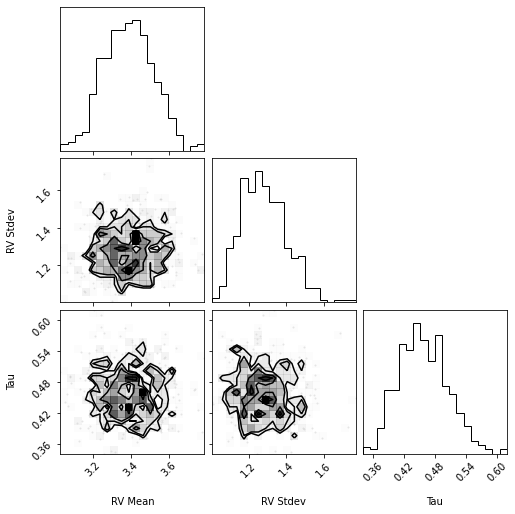

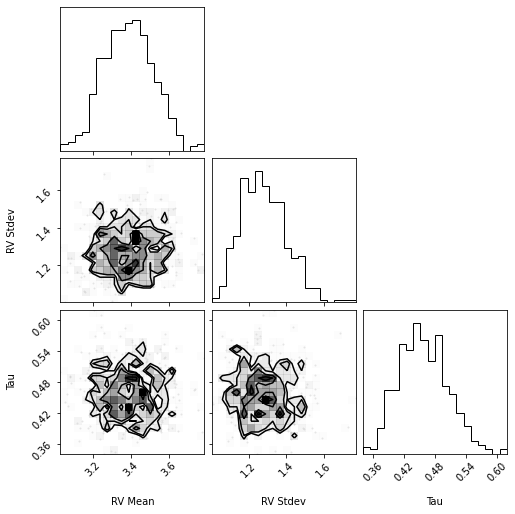

In [ ]:
corner.corner(np.vstack((rv_mean_samples, rv_std_samples,tau_samples)).T, labels = ['RV Mean', 'RV Stdev', 'Tau'])

In [ ]:
np.exp(-0.08058631) ## rv mean (maybe)

0.9225752726755495

In [ ]:
np.exp(-0.9666319) ## rv std

0.38036198027756646

In [ ]:
np.exp(-0.12967519)  ## rv tau

0.8783806914227026

In [ ]:
trained_guide.get_posterior().mean.detach().numpy()[:200]

array([-0.08058631, -0.9666319 , -0.12967519,  3.05821652,  2.97798113,
        2.93484039,  3.30535408,  2.74831781,  2.94354369,  3.00383134,
        3.23683016,  3.41978453,  2.93465272,  2.93532166,  2.9328238 ,
        2.93485712,  2.9281466 ,  2.53859547,  2.92961942,  1.98254563,
        2.92160296,  2.93354721,  3.35565871,  1.09354709,  2.9323892 ,
        3.05691125,  2.92670307,  2.58252653,  2.93508601,  2.97503705,
        2.66894817,  2.93457711,  3.10357243,  3.13997436,  3.06841706,
        2.85162249,  1.3486858 ,  3.41027294,  2.96760607,  2.59790718,
        2.93413548,  2.93476637,  2.93541354,  2.93364274,  2.01982368,
        2.93166137,  2.95041788,  3.84142034,  3.51895995,  3.3612377 ,
        2.93103939,  2.61243598,  2.65683992,  3.07871989,  2.93482986,
        2.93575384,  1.96573241,  3.28515962,  3.14101384,  3.02023823,
        3.13557126,  2.92032984,  2.92006701,  3.67076871,  2.95514191,
        2.92335959,  2.93067224,  3.53355782,  2.93195739,  2.92

In [ ]:
autoguide_laplace = pyro.infer.autoguide.AutoMultivariateNormal(training_model_vectorized)

In [ ]:
autoguide_laplace = pyro.infer.autoguide.AutoLaplaceApproximation(model_vi_with_params_faster)
train_with_params_faster(model_vi_with_params_faster, autoguide_laplace, n_steps=3000, verbose = True)

ValueError: ignored

In [ ]:
 # laplace_samples = {}
laplace_vi_loc = {}
laplace_vi_scale_tril = {}

# laplace_approxes = {}

# laplace_no_vi_loc = {}
# laplace_no_vi_scale_tril = {}

for sn in meta.SNID.values[:1]:
  print(sn)

  tmax = tmax_dict[sn]
  z_helio = z_helio_dict[sn]
  EBV_MW = mwebv_dict[sn]
  z_cmb = z_cmb_dict[sn]

  Av_obs = EBV_MW * 3.1
  observed_fluxes, flux_errors, times_dict = get_fluxes_from_file(sn + ".dat", tmax, z_helio)

  # Calculate band-dependent quantities (Jl, Jt, xis, S0, etc.)
  band_Jt, band_Jl, band_xis_matrix, band_S0, band_h = calculate_band_dependent_stuff(times_dict, z_helio, Av_obs)
  mu_mean = torch.as_tensor(cosmo.distmod(z_cmb).value).to(device)



  # start_time = measure_time.time()

  # autoguide_laplace = pyro.infer.autoguide.AutoLaplaceApproximation(model_vi_with_params_faster)
  # train_with_params_faster(model_vi_with_params_faster, autoguide_laplace, observed_fluxes, mu_mean, 
  #               band_Jl, band_Jt, band_xis_matrix, band_S0, band_h, flux_errors, n_steps=3000, verbose = True)
  

  # # Fit VI based on Laplace Approximation
  # new_laplace_approx_guide = autoguide_laplace.laplace_approximation(observed_fluxes, mu_mean, 
  #               band_Jl, band_Jt, band_xis_matrix, band_S0, band_h, flux_errors,)
  

  # train_with_params_faster(model_vi_with_params_faster, new_laplace_approx_guide, observed_fluxes, mu_mean, 
  #               band_Jl, band_Jt, band_xis_matrix, band_S0, band_h, flux_errors, n_steps=6000, verbose = True)

  # end_time = measure_time.time()
  # print("Time:", end_time - start_time, "seconds")

2016W


In [ ]:
len(xf)

9

In [ ]:
def rv_extinction(rv):
  c2 = -0.824 + 4.717 / rv
  c1 = 2.03 - 3.007*c2
  d1 = (xf[7]**2) / ((xf[7]**2 - x0**2)**2 + (gamma_f**2)*(xf[7]**2))
  d2 = (xf[8]**2) / ((xf[8]**2 - x0**2)**2 + (gamma_f**2)*(xf[8]**2))


  yf1 = -rv
  yf2 = 0.26469*rv/3.1 - rv
  yf3 = 0.82925*rv/3.1 - rv
  yf4 = -0.422809 + 1.00270*rv + (2.13572e-4)*(rv**2) - rv
  yf5 = -5.13540e-2 + 1.00216*rv - (7.35778e-5)*(rv**2) - rv
  yf6 = 0.700127 + 1.00184*rv - (3.32598e-5)*(rv**2) -rv
  yf7 = 1.19456 + 1.01707*rv - (5.46959e-3)*(rv**2) + (7.97809e-4)*(rv**3) - (4.45636e-5)*(rv**4) - rv
  yf8 = c1 + c2*xf[7] + c3*d1
  yf9 = c1 + c2*xf[8] + c3*d2

  # const_matrix = []
  return np.array([yf1, yf2, yf3, yf4, yf5, yf6, yf7, yf8, yf9])

In [ ]:
1 + rv_extinction(1.5) / 1.5

array([0.        , 0.08538387, 0.2675    , 0.72114769, 0.96781363,
       1.46854144, 1.80688362, 7.65208106, 8.02364129])

In [ ]:
1 + rv_extinction(1.5) / 1.5

array([0.        , 0.08538387, 0.2675    , 0.72114769, 0.96781363,
       1.46854144, 1.80688362, 3.86375019, 4.23531041])

In [ ]:
(1 / xf)*1e4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


array([   inf, 26500., 12200.,  6000.,  5470.,  4670.,  4110.,  2700.,
        2600.])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


(3000.0, 18000.0)

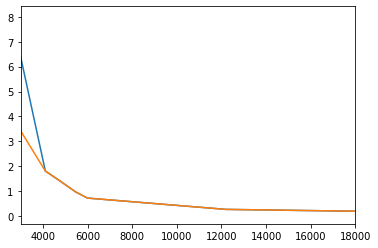

In [ ]:
plt.plot(1/xf * 1e4, [0.        , 0.08538387, 0.2675    , 0.72114769, 0.96781363, 1.46854144, 1.80688362, 7.65208106, 8.02364129])
plt.plot(1/xf * 1e4, 1 + rv_extinction(1.5) / 1.5)
plt.xlim(3000, 18000)

In [ ]:
extinction.fitzpatrick99(xf, 1., 1.5, unit = 'invum')

array([-1.48029737e-16,  8.53838710e-02,  2.67500000e-01,  7.21147691e-01,
        9.67813633e-01,  1.46854144e+00,  1.80688362e+00,  3.86375019e+00,
        4.23531041e+00])